### **Import Library**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf # Untuk mengatur seed demi reproducibility
import plotly.express as px
import matplotlib.pyplot as plt


### **Import Data Hasil Rules**

In [7]:
df = pd.read_csv('D:/kuliah/PA/sakinah-mart/data/rules2024.csv')
df.head()

,Unnamed: 0,antecedents,consequents,support,confidence,lift
0,0,"frozenset({'SAKINAH 1500ML', 'GREENFIELDS COKL...",frozenset({'GREENFIELDS STRAW 105ML'}),0.000109,1,4922.846154
1,1,"frozenset({'BISKUAT BOLU CKL 16GR', 'INDOMILK ...","frozenset({'INDOMILK KID VNL 115ML', 'CLOUD 9 ...",0.000141,1,2206.793103
2,2,"frozenset({'GATSBY SPL/C GS 175ML', 'FRESHCARE...",frozenset({'GATSBY SPL/C DO 175ML'}),0.000141,1,1185.129630
3,3,"frozenset({'KISPRAY POUCH GLAM/GLD 300ML', 'IN...",frozenset({'SOKLIN LIQ LAVENDER 625ML'}),0.000109,1,831.129870
4,4,"frozenset({'SEDAAP MIE CUP BASO BLEDUK', 'SEDA...",frozenset({'SEDAAP MIE CUP SOTO'}),0.000125,1,780.451220


In [8]:
# Pastikan semua elemen dalam kolom antecedents dan consequents adalah frozenset
df["antecedents"] = df["antecedents"].apply(lambda x: frozenset(eval(x)) if isinstance(x, str) else x)
df["consequents"] = df["consequents"].apply(lambda x: frozenset(eval(x)) if isinstance(x, str) else x)

# Mengambil semua item unik
all_items = set()
for col in ["antecedents", "consequents"]:
    for items in df[col]:
        all_items.update(items)

all_items

{'ADEM SARI CHINGKU MD LMN 350ML',
 'ATTACK JAZ 1 CINTA 1 6 KG',
 'BISKUAT BOLU CKL 16GR',
 'CLOUD 9 CHOCO 15 4G',
 'CLOUD 9 VANILA 15 4G',
 'DAIA LEMON 65GR',
 'DELFI TOP B/WHITE 9GR',
 'DELFI TOP CHO 9GR',
 'DELFI TOP STR 9GR',
 'DELFI TOP TRIP/CHO 9GR',
 'EKONOMI LIQUID REFF 235ML',
 'FRESHCARE ORIGINAL 10ML',
 'GATSBY SPL/C DO 175ML',
 'GATSBY SPL/C GS 175ML',
 'GREENFIELDS COKLAT 105ML',
 'GREENFIELDS STRAW 105ML',
 'INDOMIE GRG SPECIAL',
 'INDOMIE RAMEN TORI KARA/20',
 'INDOMIE SOTO MIE',
 'INDOMILK KID CKL 115ML',
 'INDOMILK KID STR 115ML',
 'INDOMILK KID VNL 115ML',
 'KISPRAY POUCH GLAM/GLD 300ML',
 'MAMA LEMON 115ML',
 'MOMOGI JGG BKR 6GR',
 'MR POTATO CRIPS ORI 35G',
 'NEXTAR BROWNIES 42GR',
 'NEXTAR PINEAPLE 112G',
 'NUVO SOAP BLUE 72G',
 'NUVO SOAP RED 72G',
 'ROMA KELAPA 300GR',
 'SAKINAH 1500ML',
 'SEDAAP MIE AYAM BWG',
 'SEDAAP MIE CUP AYM JERIT /12',
 'SEDAAP MIE CUP BASO BLEDUK',
 'SEDAAP MIE CUP BASO SPC',
 'SEDAAP MIE CUP KARE',
 'SEDAAP MIE CUP SOTO',
 'SEDAAP MIE S

### **Import Data Transaksi**

In [9]:
groceries = pd.read_excel('D:/kuliah/PA/sakinah-mart/data/final_data2024.xlsx')
groceries

,TANGGAL,NO TRANSAKSI,NAMA BARANG,QTY
0,2024-01-01,2401011010001,GULA ROSE BRAND 1KG,1
1,2024-01-01,2401011010002,RIZKI MG 850ML/900ML BTL,3
2,2024-01-01,2401011010003,ULTRA MIMI VNL 125ML,1
3,2024-01-01,2401011010003,BEAR BRAND 189ML,1
4,2024-01-01,2401011010003,TINI WINI BITI ASIN 20 GR,1
...,...,...,...,...
167618,2024-12-31,2412311020122,WALLS POPULAIRE CKL,1
167619,2024-12-31,2412311020123,THERMAL 80X50 TRUST PAPER,1
167620,2024-12-31,2412311020124,SAKINAH 600ML,1
167621,2024-12-31,2412311020124,WALLS PP RAINBOW P,1


### **Filter Data Transaksi**

In [10]:
df_filtered = groceries[groceries['NAMA BARANG'].isin(all_items)]
df_filtered 

,TANGGAL,NO TRANSAKSI,NAMA BARANG,QTY
20,2024-01-01,2401011010011,INDOMIE GRG SPECIAL,1
32,2024-01-01,2401011010015,EKONOMI LIQUID REFF 235ML,1
55,2024-01-01,2401011010017,ROMA KELAPA 300GR,1
59,2024-01-01,2401011010018,INDOMILK KID VNL 115ML,1
73,2024-01-01,2401011010023,ROMA KELAPA 300GR,1
...,...,...,...,...
167537,2024-12-31,2412311020090,INDOMILK KID CKL 115ML,1
167552,2024-12-31,2412311020096,INDOMIE RAMEN TORI KARA/20,1
167607,2024-12-31,2412311020118,INDOMILK KID STR 115ML,1
167608,2024-12-31,2412311020118,INDOMILK KID VNL 115ML,1


In [11]:
# Menampilkan jumlah unik nama barang
jumlah_nama_barang = df_filtered['NAMA BARANG'].nunique()
print("Jumlah nama barang unik:", jumlah_nama_barang)

# Menampilkan isi nama barang yang unik
nama_barang_unik = df_filtered['NAMA BARANG'].unique()
print("Nama barang unik:")
for nama in nama_barang_unik:
    print("-", nama)

Jumlah nama barang unik: 45
Nama barang unik:
- INDOMIE GRG SPECIAL
- EKONOMI LIQUID REFF 235ML
- ROMA KELAPA 300GR
- INDOMILK KID VNL 115ML
- SEDAAP MIE AYAM BWG
- SEDAAP MIE SOTO
- ATTACK JAZ 1 CINTA 1 6 KG
- WALLS POPULAIRE CKL
- MAMA LEMON 115ML
- WALLS CORN STRW VANILA
- DELFI TOP CHO 9GR
- DELFI TOP STR 9GR
- DELFI TOP B/WHITE 9GR
- SEDAAP MIE CUP SOTO
- SEDAAP MIE CUP KARE
- DELFI TOP TRIP/CHO 9GR
- DAIA LEMON 65GR
- NUVO SOAP RED 72G
- NUVO SOAP BLUE 72G
- SEDAAP MIE CUP AYM JERIT /12
- SEDAAP MIE CUP BASO BLEDUK
- WALLS CORN B/WHITE 82GR
- BISKUAT BOLU CKL 16GR
- INDOMIE SOTO MIE
- SOKLIN LIQ LAVENDER 625ML
- INDOMILK KID STR 115ML
- WALLS POPULAIRE STR
- SAKINAH 1500ML
- KISPRAY POUCH GLAM/GLD 300ML
- MR POTATO CRIPS ORI 35G
- INDOMILK KID CKL 115ML
- GATSBY SPL/C DO 175ML
- GATSBY SPL/C GS 175ML
- FRESHCARE ORIGINAL 10ML
- INDOMIE RAMEN TORI KARA/20
- NEXTAR BROWNIES 42GR
- CLOUD 9 VANILA 15 4G
- TEH GELAS ORI 170ML
- CLOUD 9 CHOCO 15 4G
- NEXTAR PINEAPLE 112G
- SEDAAP MIE C

### **Agregasi Data Mingguan**

In [12]:
# Agregasi jumlah QTY per tanggal dan nama barang
df_grouped = df_filtered.groupby(['TANGGAL', 'NAMA BARANG'], as_index=False)['QTY'].sum()

tanggal_range = pd.date_range(start='2024-01-01', end='2024-12-31')
all_items = df_filtered['NAMA BARANG'].unique()

# Buat kombinasi semua tanggal dan item
multi_index = pd.MultiIndex.from_product([tanggal_range, all_items], names=['TANGGAL', 'NAMA BARANG'])
all_combinations = pd.DataFrame(index=multi_index).reset_index()

# Gabungkan dengan hasil groupby
df_joined = pd.merge(all_combinations, df_grouped, on=['TANGGAL', 'NAMA BARANG'], how='left')
df_joined['QTY'] = df_joined['QTY'].fillna(0)

# Pastikan TANGGAL dalam datetime
df_joined['TANGGAL'] = pd.to_datetime(df_joined['TANGGAL'])

# Urutkan dulu datanya
df_joined = df_joined.sort_values('TANGGAL')

# Ambil tanggal paling awal
start_date = df_joined['TANGGAL'].min()

# Hitung minggu ke-n secara manual (tiap 7 hari)
df_joined['WEEK_NUMBER'] = ((df_joined['TANGGAL'] - start_date).dt.days // 7) + 1

# Agregasi berdasarkan minggu dan nama barang
df_weekly = df_joined.groupby(['WEEK_NUMBER', 'NAMA BARANG'], as_index=False)['QTY'].sum()

# (Opsional) Tambahkan kolom tanggal mulai minggu
df_weekly['TANGGAL'] = start_date + pd.to_timedelta((df_weekly['WEEK_NUMBER'] - 1) * 7, unit='D')

# Visualisasi
fig = px.line(df_weekly, x='TANGGAL', y='QTY', color='NAMA BARANG',
              title='Jumlah Penjualan per Minggu (Setiap 7 Hari)')
fig.update_layout(legend_title_text='Klik untuk tampilkan/sembunyikan item')
fig.show()

In [13]:
df_weekly

,WEEK_NUMBER,NAMA BARANG,QTY,TANGGAL
0,1,ADEM SARI CHINGKU MD LMN 350ML,0.0,2024-01-01
1,1,ATTACK JAZ 1 CINTA 1 6 KG,10.0,2024-01-01
2,1,BISKUAT BOLU CKL 16GR,5.0,2024-01-01
3,1,CLOUD 9 CHOCO 15 4G,3.0,2024-01-01
4,1,CLOUD 9 VANILA 15 4G,4.0,2024-01-01
...,...,...,...,...
2380,53,TEH GELAS ORI 170ML,0.0,2024-12-30
2381,53,WALLS CORN B/WHITE 82GR,0.0,2024-12-30
2382,53,WALLS CORN STRW VANILA,0.0,2024-12-30
2383,53,WALLS POPULAIRE CKL,9.0,2024-12-30


### **Pivot Data**

In [15]:
df_pivoted= df_weekly.pivot(index='TANGGAL', columns='NAMA BARANG', values='QTY')
df_pivoted.columns.name = None  # hilangkan nama kolom atas
df_pivoted = df_pivoted.reset_index() 
df_pivoted.head()

,TANGGAL,ADEM SARI CHINGKU MD LMN 350ML,ATTACK JAZ 1 CINTA 1 6 KG,BISKUAT BOLU CKL 16GR,CLOUD 9 CHOCO 15 4G,CLOUD 9 VANILA 15 4G,DAIA LEMON 65GR,DELFI TOP B/WHITE 9GR,DELFI TOP CHO 9GR,DELFI TOP STR 9GR,...,SEDAAP MIE CUP BASO SPC,SEDAAP MIE CUP KARE,SEDAAP MIE CUP SOTO,SEDAAP MIE SOTO,SOKLIN LIQ LAVENDER 625ML,TEH GELAS ORI 170ML,WALLS CORN B/WHITE 82GR,WALLS CORN STRW VANILA,WALLS POPULAIRE CKL,WALLS POPULAIRE STR
0,2024-01-01,0.0,10.0,5.0,3.0,4.0,5.0,6.0,8.0,5.0,...,0.0,2.0,5.0,38.0,2.0,3.0,17.0,2.0,10.0,4.0
1,2024-01-08,10.0,0.0,4.0,7.0,1.0,2.0,7.0,4.0,4.0,...,2.0,3.0,1.0,16.0,2.0,5.0,12.0,4.0,3.0,4.0
2,2024-01-15,8.0,0.0,7.0,5.0,7.0,0.0,3.0,1.0,3.0,...,2.0,3.0,2.0,20.0,0.0,4.0,3.0,0.0,7.0,7.0
3,2024-01-22,2.0,1.0,5.0,5.0,7.0,2.0,4.0,2.0,0.0,...,2.0,2.0,0.0,32.0,1.0,10.0,22.0,5.0,7.0,6.0
4,2024-01-29,0.0,5.0,0.0,10.0,7.0,3.0,9.0,10.0,5.0,...,2.0,0.0,2.0,16.0,2.0,9.0,8.0,2.0,8.0,5.0


In [16]:
# 1. Pisahkan kolom tanggal dan kolom produk
produk_df = df_pivoted.drop(columns=["TANGGAL"])

# 2. Hitung jumlah 0 per kolom
zero_counts = (produk_df == 0).sum()

# 3. Ambil item yang jumlah 0-nya <= 5
filtered_items = zero_counts[zero_counts <= 5].index

# 4. Filter dataframe hanya dengan item yang lolos kriteria 0
filtered_df = produk_df[filtered_items]

# 5. Hitung total penjualan per item
total_sales = filtered_df.sum().sort_values(ascending=False).index

# 6. Ambil 15 item dengan total penjualan tertinggi
# top_3_items = total_sales.head(15).index

# 7. Final dataframe dengan 15 item terbaik
df_final = df_pivoted[["TANGGAL"] + total_sales.tolist()]

In [17]:
df_final.head()

,TANGGAL,INDOMIE GRG SPECIAL,INDOMILK KID CKL 115ML,SEDAAP MIE SOTO,SAKINAH 1500ML,INDOMILK KID VNL 115ML,INDOMILK KID STR 115ML,INDOMIE SOTO MIE,SEDAAP MIE AYAM BWG,EKONOMI LIQUID REFF 235ML,WALLS CORN B/WHITE 82GR,WALLS POPULAIRE CKL,WALLS POPULAIRE STR,MAMA LEMON 115ML,DELFI TOP CHO 9GR,ROMA KELAPA 300GR,DELFI TOP B/WHITE 9GR,BISKUAT BOLU CKL 16GR,DELFI TOP STR 9GR
0,2024-01-01,129.0,3.0,38.0,6.0,8.0,3.0,18.0,14.0,9.0,17.0,10.0,4.0,3.0,8.0,12.0,6.0,5.0,5.0
1,2024-01-08,119.0,12.0,16.0,6.0,13.0,14.0,13.0,1.0,6.0,12.0,3.0,4.0,6.0,4.0,8.0,7.0,4.0,4.0
2,2024-01-15,88.0,13.0,20.0,5.0,10.0,10.0,16.0,9.0,4.0,3.0,7.0,7.0,7.0,1.0,6.0,3.0,7.0,3.0
3,2024-01-22,147.0,18.0,32.0,8.0,14.0,16.0,19.0,3.0,6.0,22.0,7.0,6.0,8.0,2.0,3.0,4.0,5.0,0.0
4,2024-01-29,114.0,20.0,16.0,4.0,19.0,22.0,15.0,5.0,11.0,8.0,8.0,5.0,7.0,10.0,6.0,9.0,0.0,5.0


In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   TANGGAL                    53 non-null     datetime64[ns]
 1   INDOMIE GRG SPECIAL        53 non-null     float64       
 2   INDOMILK KID CKL 115ML     53 non-null     float64       
 3   SEDAAP MIE SOTO            53 non-null     float64       
 4   SAKINAH 1500ML             53 non-null     float64       
 5   INDOMILK KID VNL 115ML     53 non-null     float64       
 6   INDOMILK KID STR 115ML     53 non-null     float64       
 7   INDOMIE SOTO MIE           53 non-null     float64       
 8   SEDAAP MIE AYAM BWG        53 non-null     float64       
 9   EKONOMI LIQUID REFF 235ML  53 non-null     float64       
 10  WALLS CORN B/WHITE 82GR    53 non-null     float64       
 11  WALLS POPULAIRE CKL        53 non-null     float64       
 12  WALLS POPU

In [19]:
# Ubah kolom TANGGAL menjadi datetime
df_final["TANGGAL"] = pd.to_datetime(df_final["TANGGAL"])

# Ubah dari wide ke long format agar cocok untuk plotly express
df_long = df_final.melt(id_vars="TANGGAL", var_name="NAMA BARANG", value_name="QTY")

# Buat line chart
fig = px.line(
    df_long,
    x="TANGGAL",
    y="QTY",
    color="NAMA BARANG",
    title="Jumlah Penjualan per Minggu per Item",
    markers=True,
    labels={"TANGGAL": "Tanggal", "QTY": "Jumlah Terjual", "NAMA BARANG": "Nama Produk"},
    hover_data={"TANGGAL": True, "QTY": True, "NAMA BARANG": True}
)

# Layout tambahan
fig.update_layout(
    legend_title_text='Klik nama produk untuk tampilkan/sembunyikan',
    xaxis_title='Tanggal',
    yaxis_title='Jumlah Terjual',
    template='plotly_white',
    height=500,
    width=900
)

fig.show()


C:\Users\ASUS\AppData\Local\Temp\ipykernel_6172\2313548066.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   TANGGAL                    53 non-null     datetime64[ns]
 1   INDOMIE GRG SPECIAL        53 non-null     float64       
 2   INDOMILK KID CKL 115ML     53 non-null     float64       
 3   SEDAAP MIE SOTO            53 non-null     float64       
 4   SAKINAH 1500ML             53 non-null     float64       
 5   INDOMILK KID VNL 115ML     53 non-null     float64       
 6   INDOMILK KID STR 115ML     53 non-null     float64       
 7   INDOMIE SOTO MIE           53 non-null     float64       
 8   SEDAAP MIE AYAM BWG        53 non-null     float64       
 9   EKONOMI LIQUID REFF 235ML  53 non-null     float64       
 10  WALLS CORN B/WHITE 82GR    53 non-null     float64       
 11  WALLS POPULAIRE CKL        53 non-null     float64       
 12  WALLS POPU

In [21]:
# Mengubah kolom TANGGAL menjadi datetime dan menjadikannya index
df_final['TANGGAL'] = pd.to_datetime(df_final['TANGGAL'])
df_final = df_final.set_index('TANGGAL')
df_final = df_final.asfreq('W-MON') # Menetapkan frekuensi mingguan (Senin)
df_final.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_6172\3852118419.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,INDOMIE GRG SPECIAL,INDOMILK KID CKL 115ML,SEDAAP MIE SOTO,SAKINAH 1500ML,INDOMILK KID VNL 115ML,INDOMILK KID STR 115ML,INDOMIE SOTO MIE,SEDAAP MIE AYAM BWG,EKONOMI LIQUID REFF 235ML,WALLS CORN B/WHITE 82GR,WALLS POPULAIRE CKL,WALLS POPULAIRE STR,MAMA LEMON 115ML,DELFI TOP CHO 9GR,ROMA KELAPA 300GR,DELFI TOP B/WHITE 9GR,BISKUAT BOLU CKL 16GR,DELFI TOP STR 9GR
TANGGAL,,,,,,,,,,,,,,,,,,
2024-01-01,129.0,3.0,38.0,6.0,8.0,3.0,18.0,14.0,9.0,17.0,10.0,4.0,3.0,8.0,12.0,6.0,5.0,5.0
2024-01-08,119.0,12.0,16.0,6.0,13.0,14.0,13.0,1.0,6.0,12.0,3.0,4.0,6.0,4.0,8.0,7.0,4.0,4.0
2024-01-15,88.0,13.0,20.0,5.0,10.0,10.0,16.0,9.0,4.0,3.0,7.0,7.0,7.0,1.0,6.0,3.0,7.0,3.0
2024-01-22,147.0,18.0,32.0,8.0,14.0,16.0,19.0,3.0,6.0,22.0,7.0,6.0,8.0,2.0,3.0,4.0,5.0,0.0
2024-01-29,114.0,20.0,16.0,4.0,19.0,22.0,15.0,5.0,11.0,8.0,8.0,5.0,7.0,10.0,6.0,9.0,0.0,5.0


             MEMULAI FORECASTING DENGAN LSTM MULTIVARIATE DAN EVALUASI             
Total data historis: 53 titik.
Ukuran data training (80%): 42 titik.
Ukuran data testing (20%): 11 titik.
Look-back window (jumlah langkah input): 2



--- Memproses Produk: INDOMIE GRG SPECIAL ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 30.80
  - RMSE: 35.66
  - MAPE: 39.39%


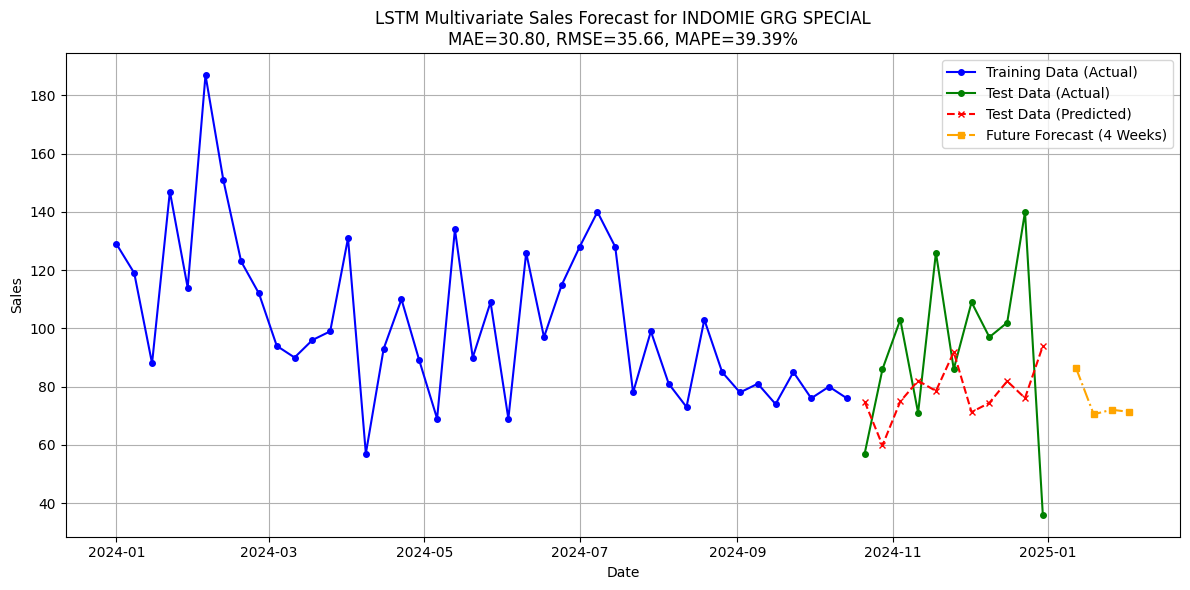


--- Memproses Produk: INDOMILK KID CKL 115ML ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 15.52
  - RMSE: 18.26
  - MAPE: 34.54%


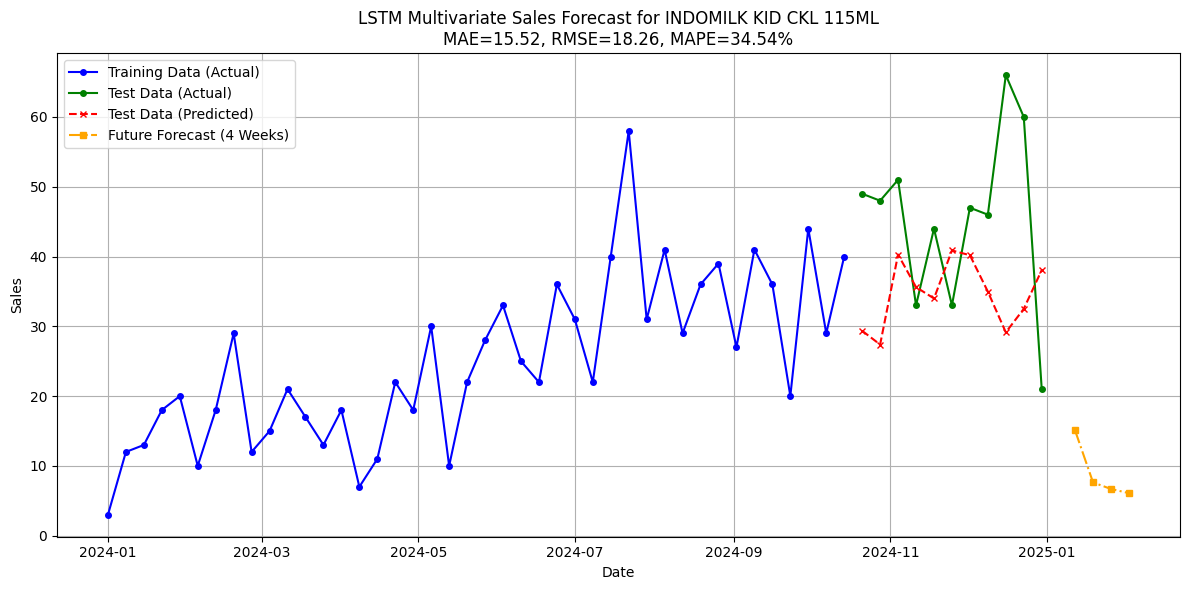


--- Memproses Produk: SEDAAP MIE SOTO ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 9.07
  - RMSE: 10.46
  - MAPE: 66.44%


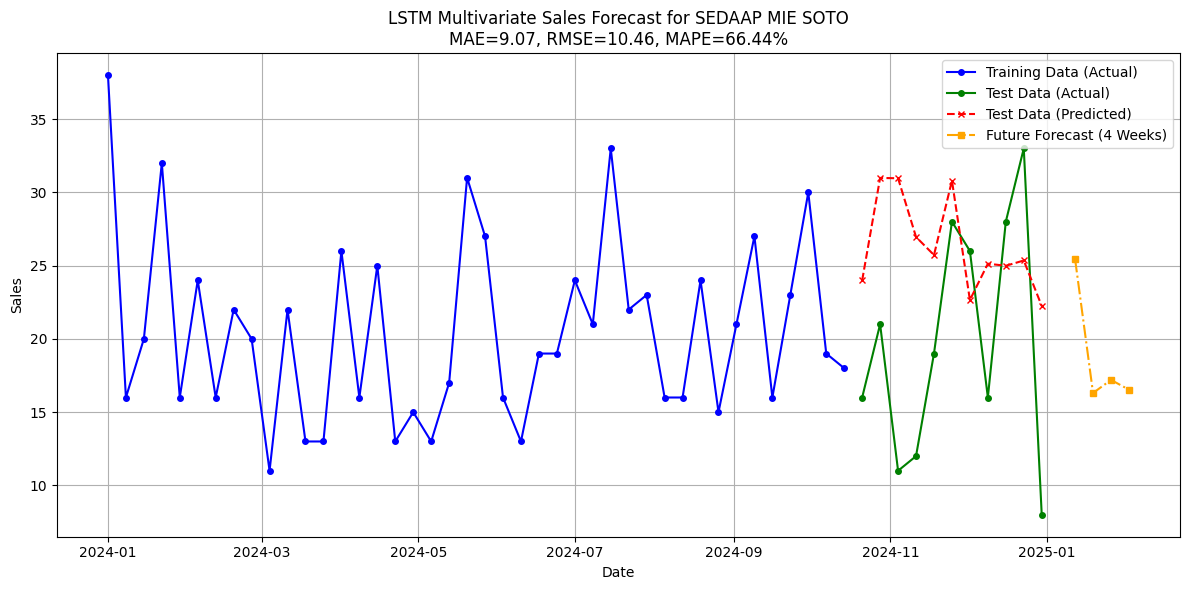


--- Memproses Produk: SAKINAH 1500ML ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 10.06
  - RMSE: 13.46
  - MAPE: 31.36%


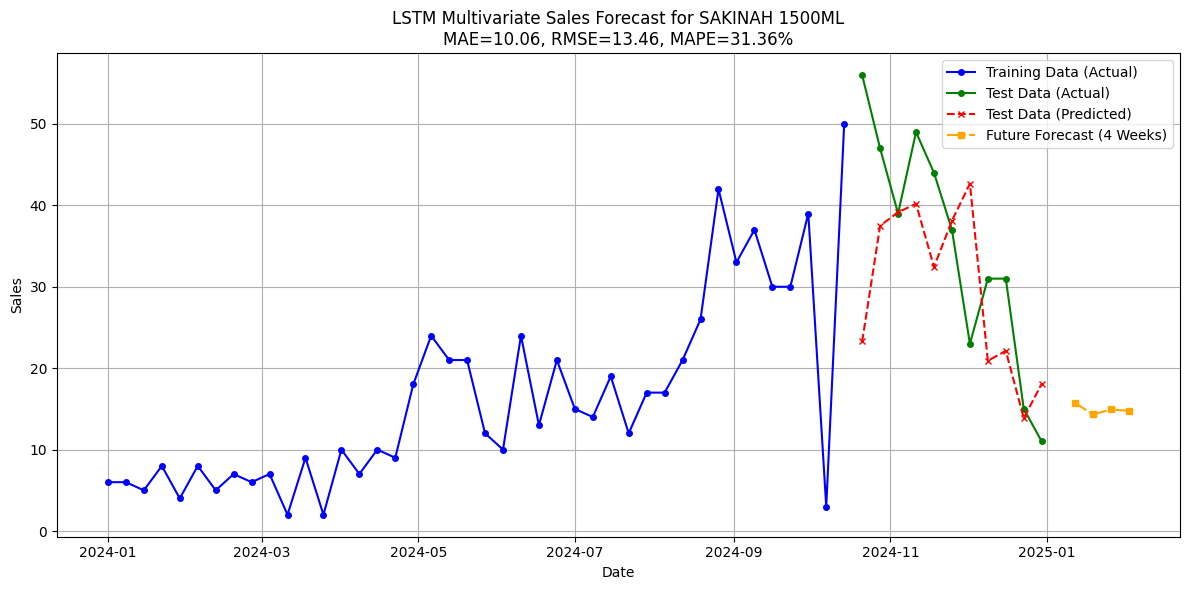


--- Memproses Produk: INDOMILK KID VNL 115ML ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 6.90
  - RMSE: 8.21
  - MAPE: 108.78%


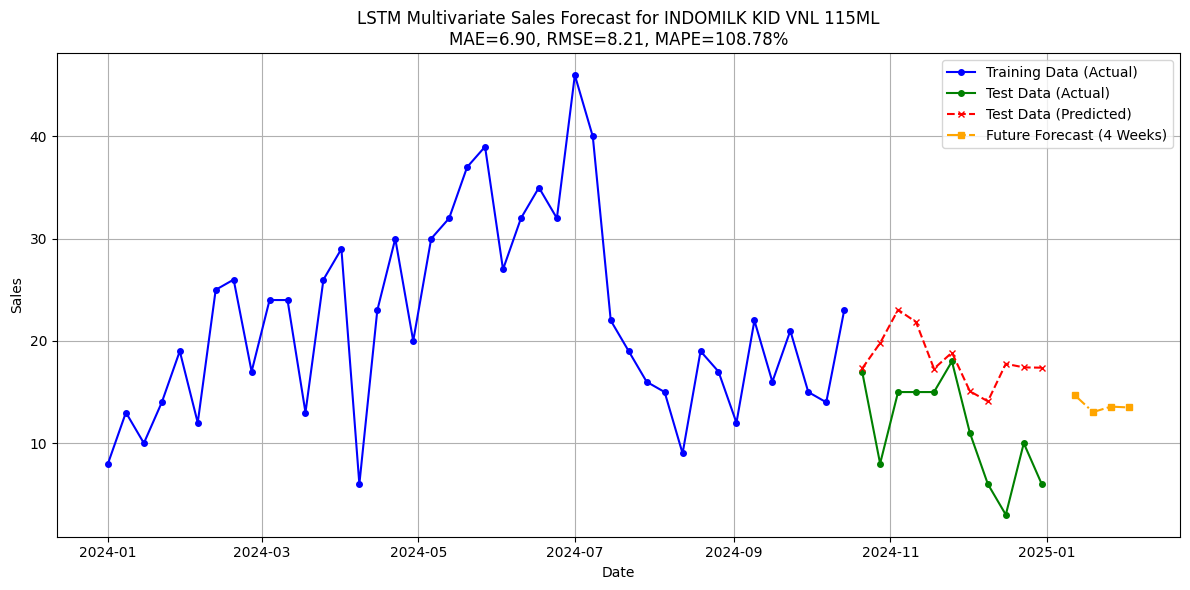


--- Memproses Produk: INDOMILK KID STR 115ML ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 5.49
  - RMSE: 6.99
  - MAPE: 80.54%


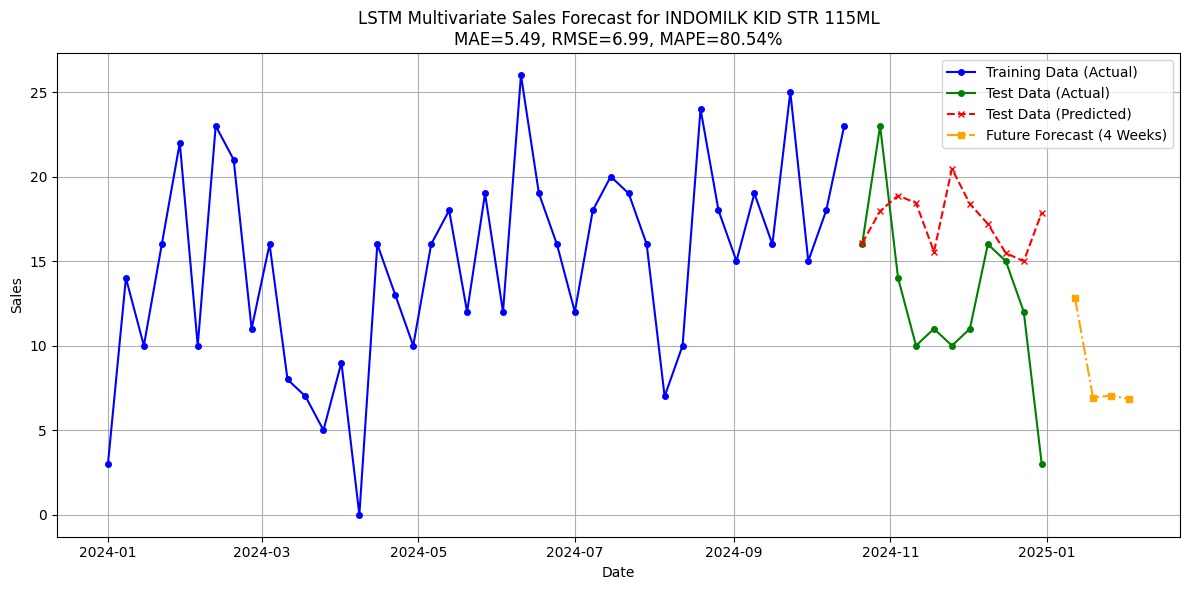


--- Memproses Produk: INDOMIE SOTO MIE ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 8.19
  - RMSE: 9.75
  - MAPE: 42.93%


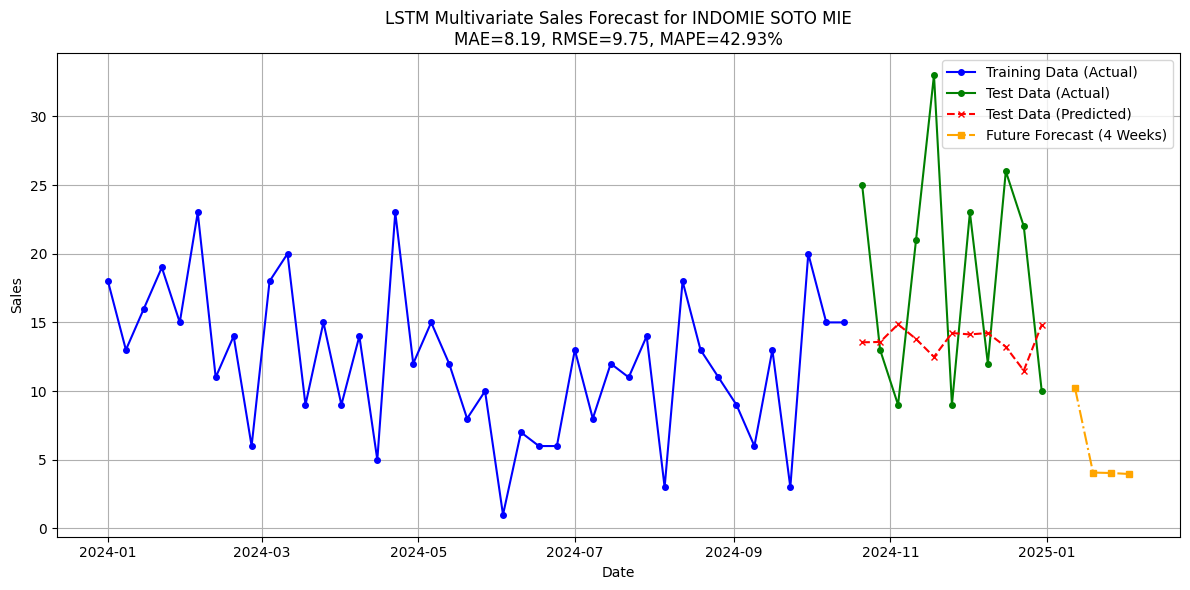


--- Memproses Produk: SEDAAP MIE AYAM BWG ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 1.84
  - RMSE: 2.53
  - MAPE: 41.53%


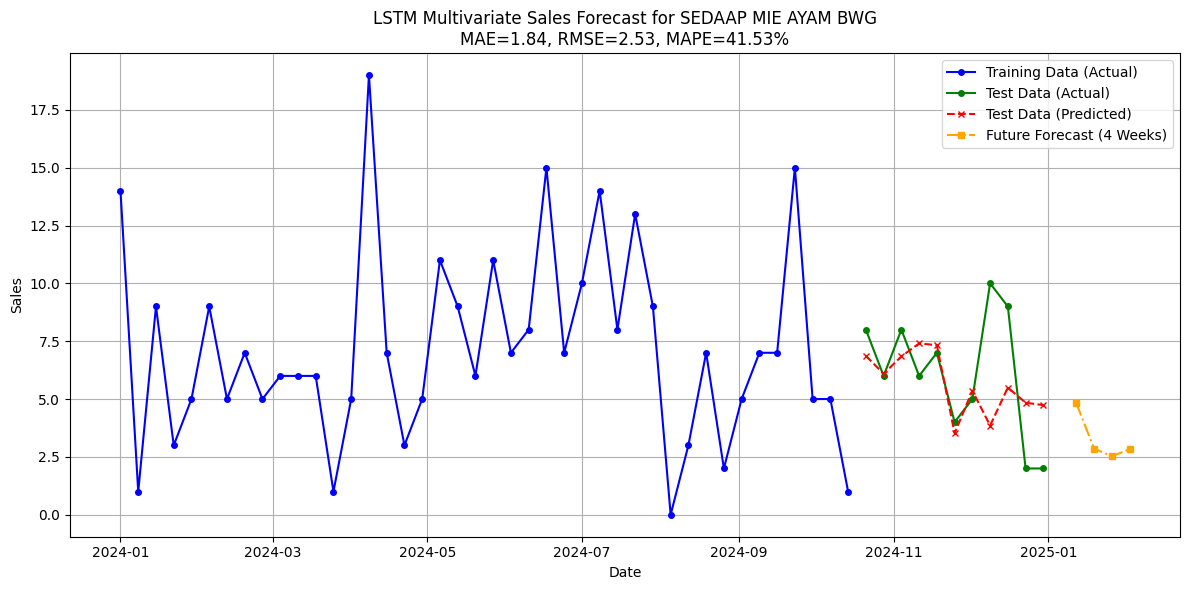


--- Memproses Produk: EKONOMI LIQUID REFF 235ML ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 5.63
  - RMSE: 6.52
  - MAPE: 192.27%


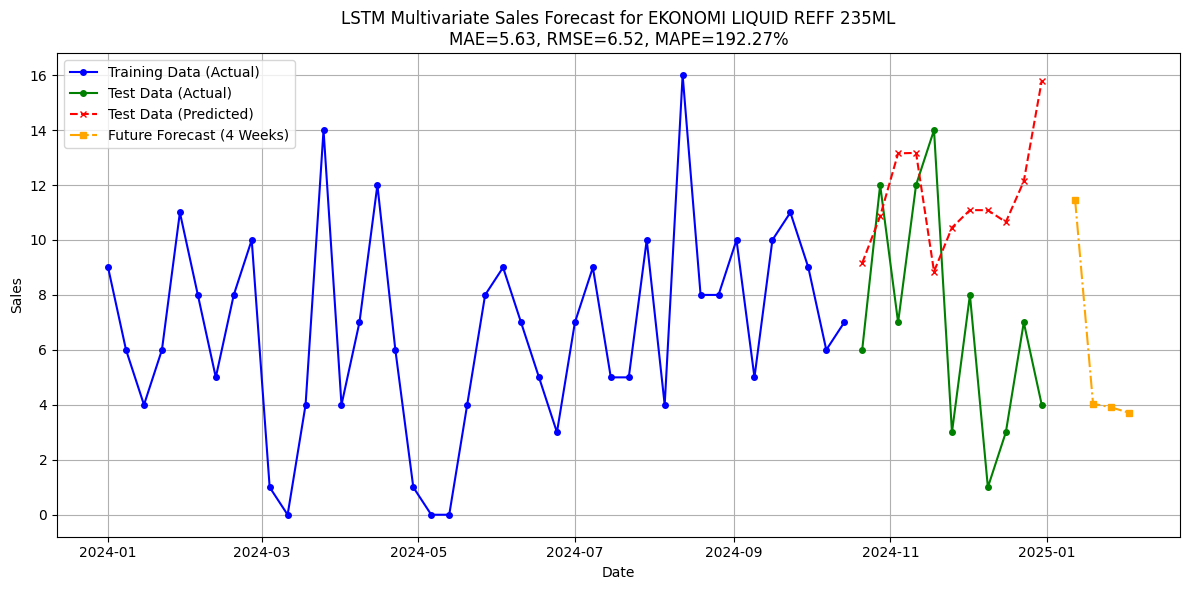


--- Memproses Produk: WALLS CORN B/WHITE 82GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 3.00
  - RMSE: 4.76
  - MAPE: 70.46%


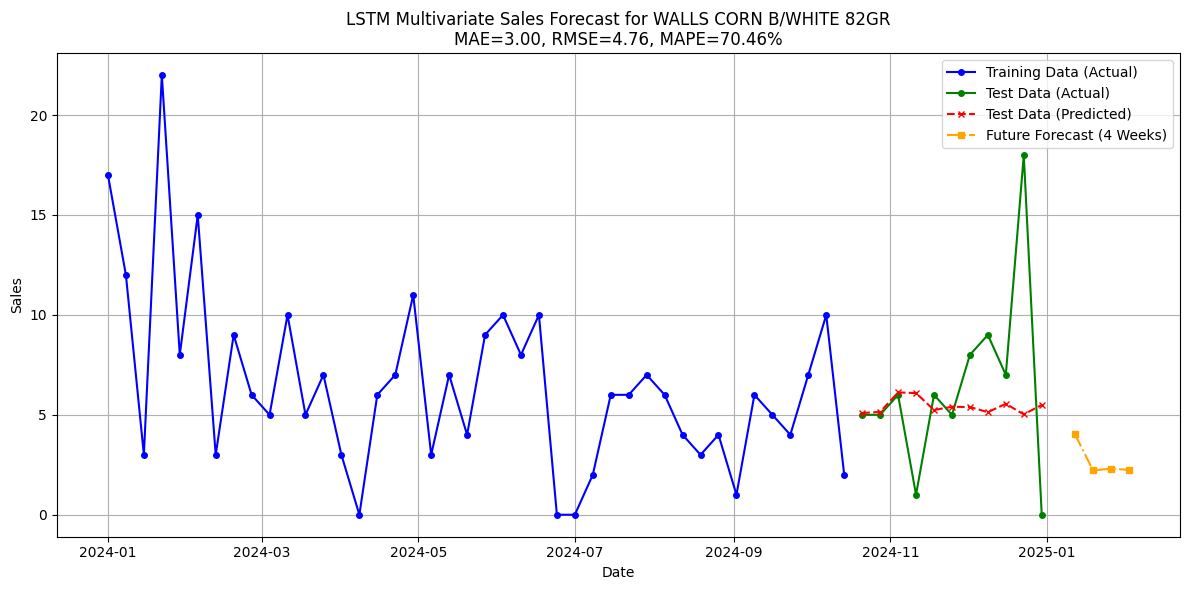


--- Memproses Produk: WALLS POPULAIRE CKL ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 1.89
  - RMSE: 2.60
  - MAPE: 29.95%


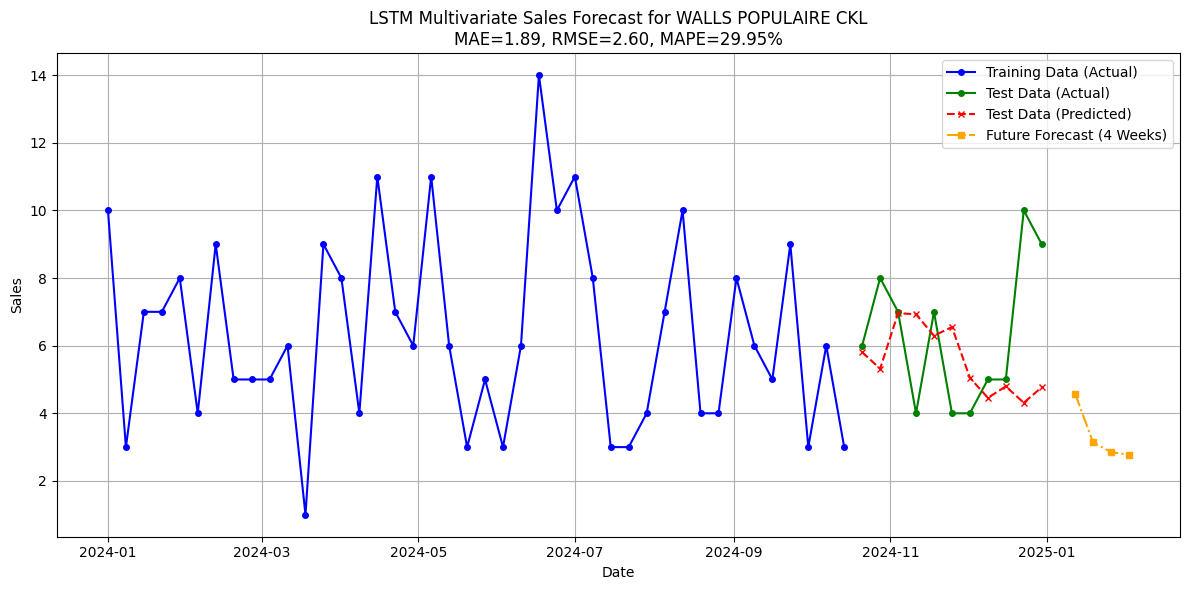


--- Memproses Produk: WALLS POPULAIRE STR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.92
  - RMSE: 3.31
  - MAPE: 102.28%


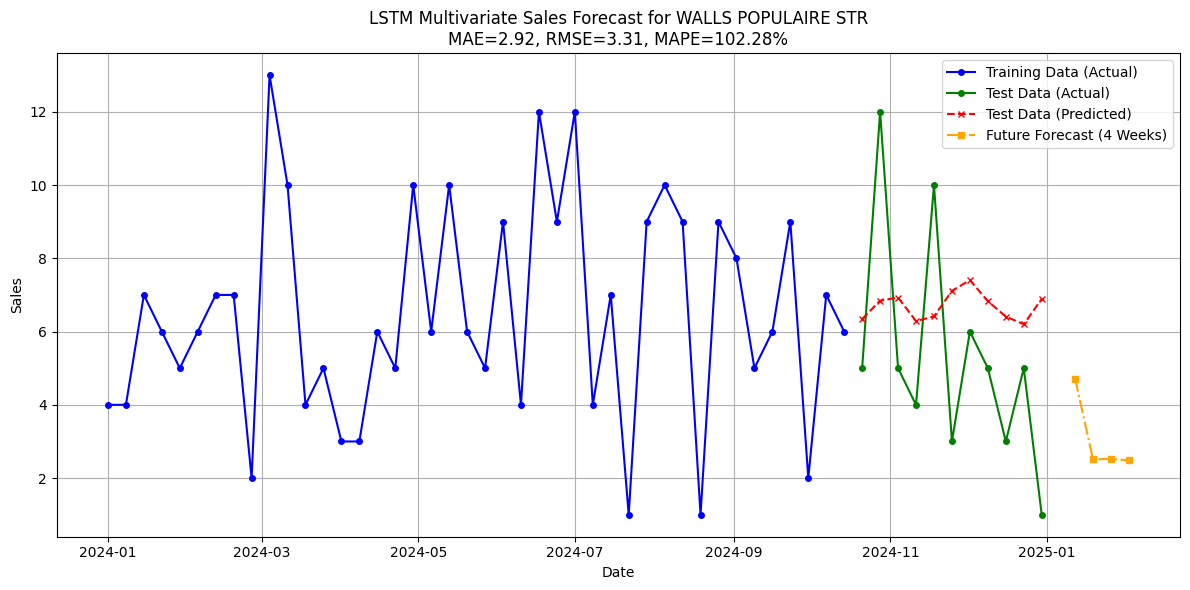


--- Memproses Produk: MAMA LEMON 115ML ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 3.12
  - RMSE: 4.02
  - MAPE: 92.52%


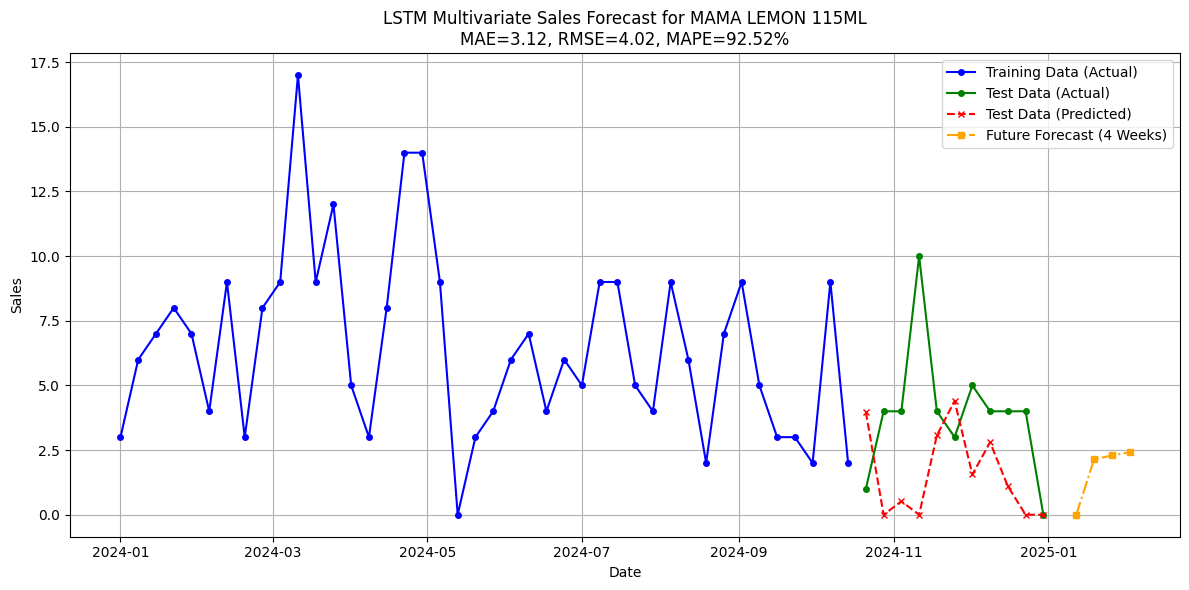


--- Memproses Produk: DELFI TOP CHO 9GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.82
  - RMSE: 3.31
  - MAPE: 75.72%


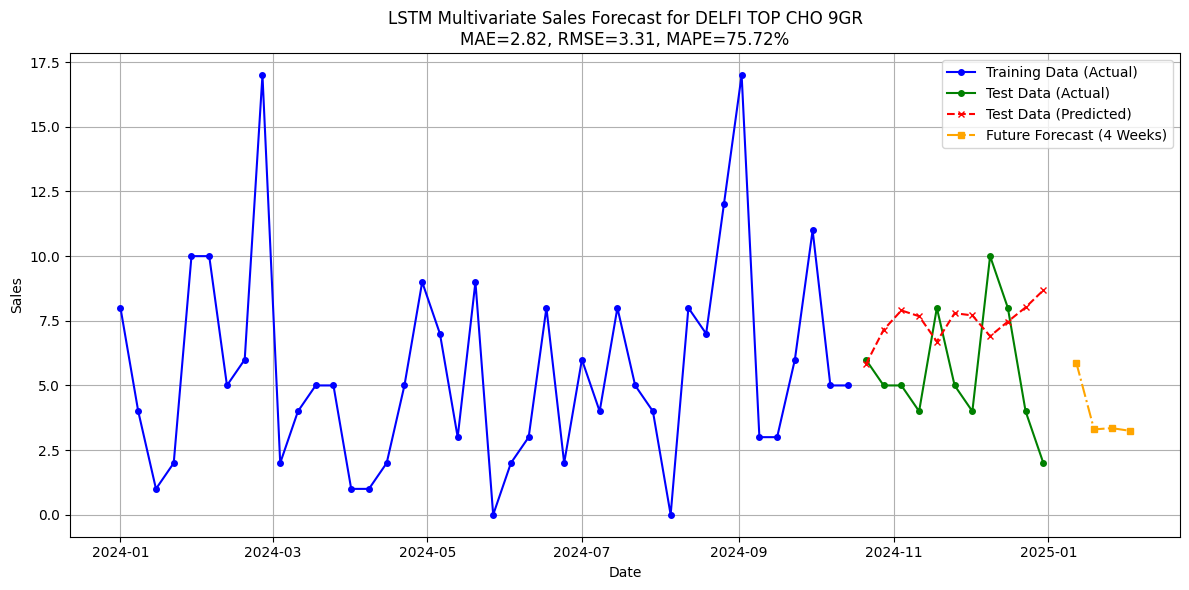


--- Memproses Produk: ROMA KELAPA 300GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.77
  - RMSE: 3.52
  - MAPE: 74.12%


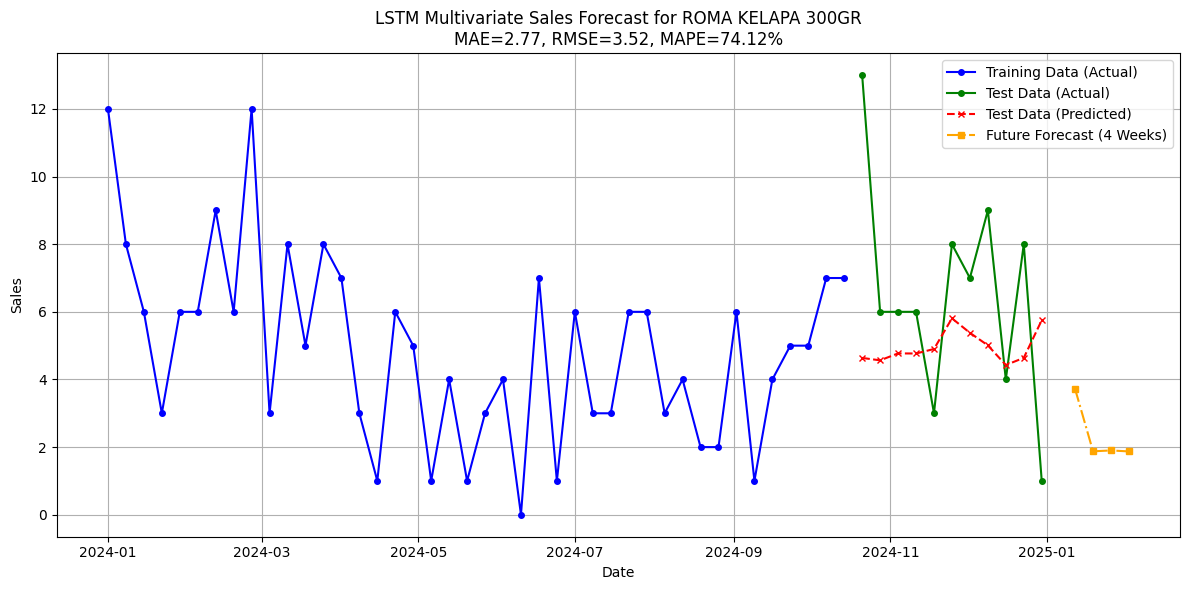


--- Memproses Produk: DELFI TOP B/WHITE 9GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 3.00
  - RMSE: 3.35
  - MAPE: 129.24%


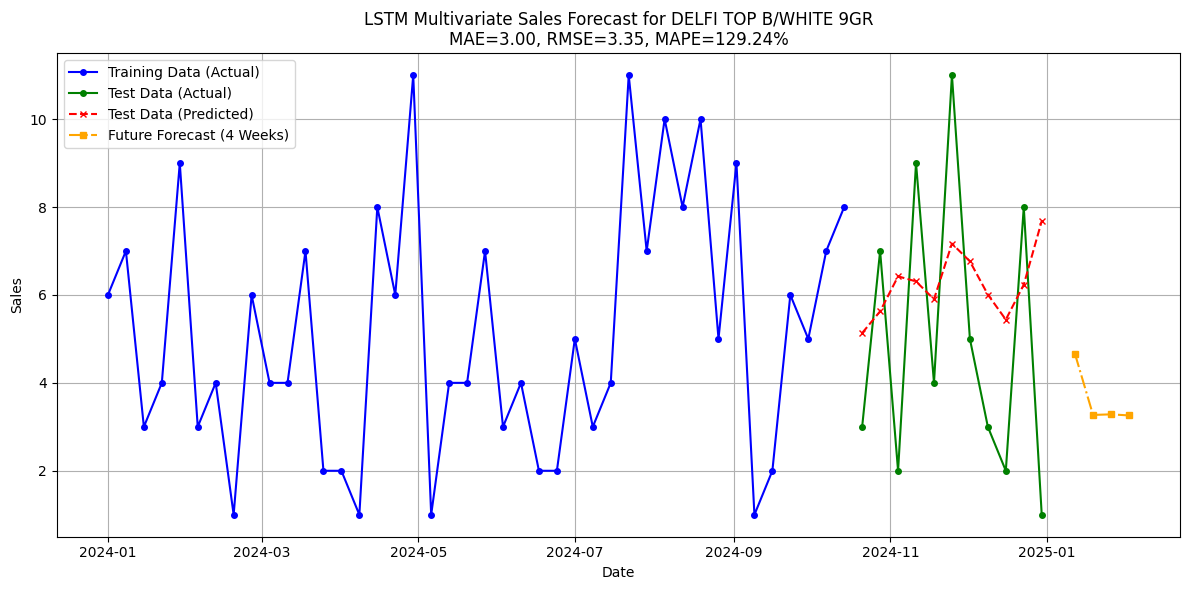


--- Memproses Produk: BISKUAT BOLU CKL 16GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.58
  - RMSE: 3.61
  - MAPE: 32.75%


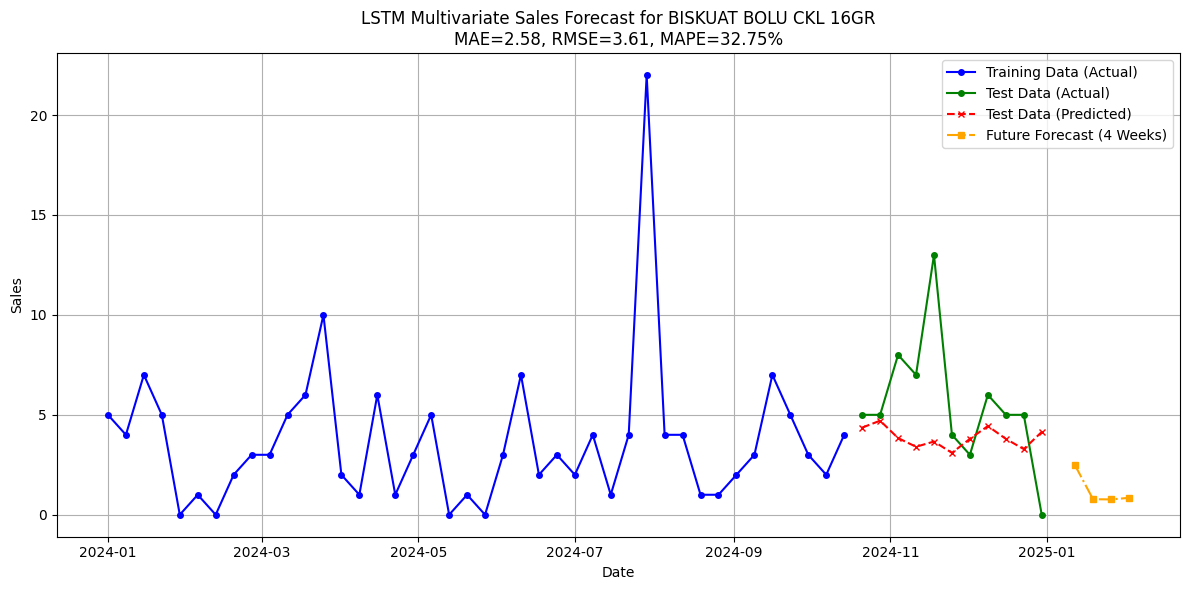


--- Memproses Produk: DELFI TOP STR 9GR ---


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



  - MAE: 2.88
  - RMSE: 3.17
  - MAPE: 182.97%


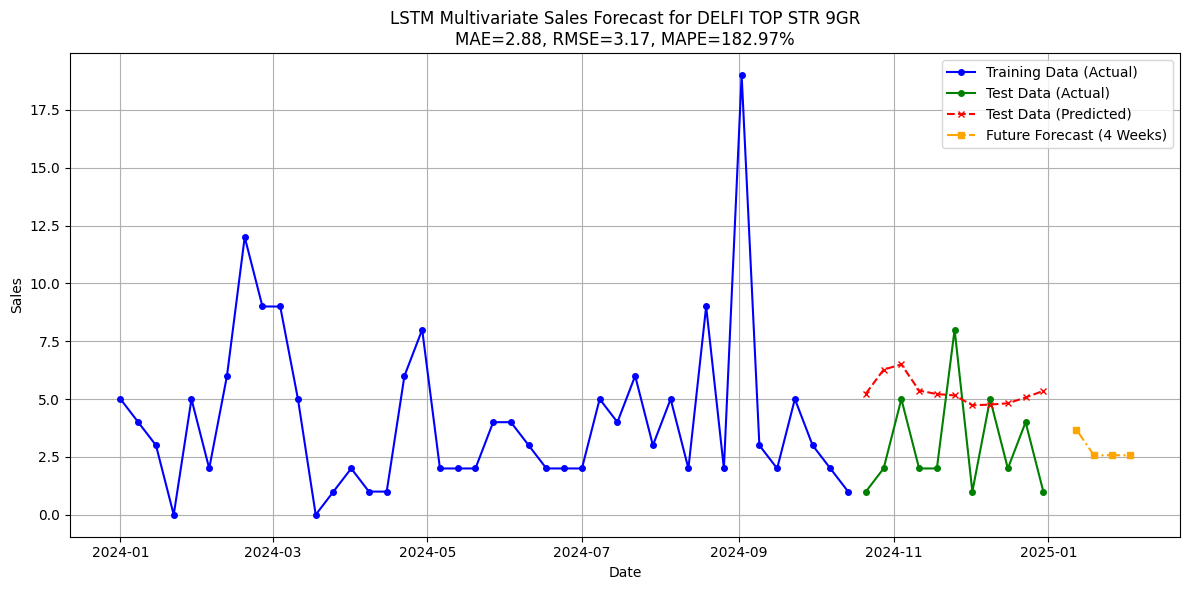



             PROSES FORECASTING DAN EVALUASI SELESAI             

--- Ringkasan Hasil Evaluasi Model (Produk dengan Akurasi Terbaik ke Terjelek) ---
                                 MAE       RMSE        MAPE
WALLS POPULAIRE CKL         1.892044   2.602412   29.945323
SAKINAH 1500ML             10.062799  13.456188   31.359001
BISKUAT BOLU CKL 16GR       2.577717   3.610400   32.751184
INDOMILK KID CKL 115ML     15.518960  18.260868   34.538758
INDOMIE GRG SPECIAL        30.800925  35.661715   39.393883
SEDAAP MIE AYAM BWG         1.835084   2.534877   41.525686
INDOMIE SOTO MIE            8.185749   9.752947   42.929349
SEDAAP MIE SOTO             9.071706  10.460776   66.442568
WALLS CORN B/WHITE 82GR     3.000826   4.759331   70.461085
ROMA KELAPA 300GR           2.772900   3.516903   74.123126
DELFI TOP CHO 9GR           2.821940   3.309662   75.722596
INDOMILK KID STR 115ML      5.486787   6.986321   80.537821
MAMA LEMON 115ML            3.120554   4.016529   92.522328
WALLS PO

In [23]:
# --- Pra-Pemrosesan Data ---
# Pastikan indeks adalah kolom 'TANGGAL'
if df_final.index.name == 'TANGGAL':
    df_final = df_final.reset_index()
elif 'TANGGAL' not in df_final.columns:
    df_final = df_final.reset_index()
    df_final.rename(columns={df_final.columns[0]: 'TANGGAL'}, inplace=True)

df_final['TANGGAL'] = pd.to_datetime(df_final['TANGGAL'])
product_columns = [col for col in df_final.columns if col != 'TANGGAL']

for col in product_columns:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce')
    df_final[col] = df_final[col].fillna(0)
    df_final[col] = np.maximum(0, df_final[col])

# --- Fungsi untuk Menghitung Metrik ---
def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    non_zero_indices = y_true != 0
    if np.sum(non_zero_indices) > 0:
        mape = np.mean(np.abs((y_true[non_zero_indices] - y_pred[non_zero_indices]) / y_true[non_zero_indices])) * 100
    else:
        mape = np.nan # Jika semua nilai aktual adalah 0, MAPE tidak terdefinisi

    return mae, rmse, mape

# --- Fungsi untuk Membuat Urutan Data untuk LSTM Multivariat ---
# 'data' kini adalah array 2D (samples, features)
# 'target_column_index' menunjukkan kolom mana yang akan diprediksi
def create_sequences_multivariate(data, look_back, target_column_index):
    X, y = [], []
    for i in range(len(data) - look_back):
        # X akan berisi semua fitur untuk periode look_back
        X.append(data[i:(i + look_back), :])
        # y akan berisi nilai target (dari target_column_index) pada langkah berikutnya
        y.append(data[i + look_back, target_column_index])
    return np.array(X), np.array(y)

# --- Hyperparameter LSTM ---
LOOK_BACK = 2 # Mengurangi LOOK_BACK karena data sangat sedikit
LSTM_UNITS = 50
EPOCHS = 100
BATCH_SIZE = 1 # Biasanya 1 untuk data deret waktu kecil
FORECAST_HORIZON = 4

# --- Persiapan Global untuk Scaling Multivariat ---
# Skala semua data produk sekaligus
all_product_data = df_final[product_columns].values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_all_data = scaler.fit_transform(all_product_data)

# --- Persiapan untuk Forecasting ---
evaluation_results = {}
future_forecasts_data_list = []

train_size = int(len(df_final) * 0.8)
test_size = len(df_final) - train_size

print("="*80)
print("             MEMULAI FORECASTING DENGAN LSTM MULTIVARIATE DAN EVALUASI             ")
print("="*80)
print(f"Total data historis: {len(df_final)} titik.")
print(f"Ukuran data training (80%): {train_size} titik.")
print(f"Ukuran data testing (20%): {test_size} titik.")
print(f"Look-back window (jumlah langkah input): {LOOK_BACK}")
print("\n")

# Jumlah fitur (kolom produk)
n_features = len(product_columns)

# Loop untuk setiap produk (model terpisah, namun input multivariat)
for product_idx, product in enumerate(product_columns):
    print(f"\n--- Memproses Produk: {product} ---")

    # Ambil data yang diskalakan
    train_scaled = scaled_all_data[:train_size]
    # Data testing perlu menyertakan LOOK_BACK sebelumnya dari training untuk membentuk urutan
    test_scaled_with_history = scaled_all_data[train_size - LOOK_BACK:]

    # Buat urutan untuk training dan testing
    # X_train dan X_test sekarang akan memiliki dimensi (samples, look_back, n_features)
    X_train, y_train = create_sequences_multivariate(train_scaled, LOOK_BACK, product_idx)
    X_test, y_test_actual_scaled = create_sequences_multivariate(test_scaled_with_history, LOOK_BACK, product_idx)

    # Pastikan ada cukup data setelah look_back untuk training/testing
    if X_train.shape[0] == 0 or X_test.shape[0] == 0:
        print(f"  Peringatan: Data tidak cukup untuk look_back ({LOOK_BACK}). Melewatkan produk.")
        evaluation_results[product] = {'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan}
        future_forecasts_data_list.append(np.full(FORECAST_HORIZON, np.nan))
        continue

    # --- Bangun Model LSTM Multivariat ---
    model = Sequential()
    # input_shape sekarang adalah (LOOK_BACK, n_features)
    model.add(LSTM(LSTM_UNITS, activation='relu', input_shape=(LOOK_BACK, n_features)))
    model.add(Dense(1)) # Tetap memprediksi 1 nilai (untuk produk saat ini)
    model.compile(optimizer='adam', loss='mse')

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

    history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                        validation_split=0.1, callbacks=[early_stopping])

    # --- Prediksi pada Data Testing ---
    y_pred_scaled = model.predict(X_test, verbose=0)

    # --- Inverse Transform Prediksi dan Aktual ---
    # Karena scaler fit pada semua fitur, kita perlu membuat dummy array untuk inverse transform
    # untuk mendapatkan nilai unscaled yang benar untuk kolom target
    dummy_pred_array = np.zeros((len(y_pred_scaled), n_features))
    dummy_pred_array[:, product_idx] = y_pred_scaled.flatten()
    y_pred_unscaled = scaler.inverse_transform(dummy_pred_array)[:, product_idx]

    dummy_actual_array = np.zeros((len(y_test_actual_scaled), n_features))
    dummy_actual_array[:, product_idx] = y_test_actual_scaled.flatten()
    y_test_actual_unscaled = scaler.inverse_transform(dummy_actual_array)[:, product_idx]

    y_pred_unscaled[y_pred_unscaled < 0] = 0 # pastikan tidak ada nilai negatif

    # --- Evaluasi Metrik ---
    mae, rmse, mape = calculate_metrics(y_test_actual_unscaled, y_pred_unscaled)

    print(f"  - MAE: {mae:.2f}")
    print(f"  - RMSE: {rmse:.2f}")
    if pd.isna(mape):
        print(f"  - MAPE: N/A (Semua nilai aktual adalah 0 di periode testing)")
    else:
        print(f"  - MAPE: {mape:.2f}%")

    evaluation_results[product] = {
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

    # --- Prediksi Masa Depan (Forecasting) ---
    # Ambil look_back terakhir dari data keseluruhan yang diskalakan sebagai input awal
    current_input = scaled_all_data[-LOOK_BACK:].reshape(1, LOOK_BACK, n_features)
    product_future_forecast_scaled = []

    # Kita perlu array yang merepresentasikan 'keadaan' fitur terakhir
    # Ini akan diperbarui dengan prediksi produk saat ini
    last_known_features_scaled = scaled_all_data[-1, :].copy()

    for _ in range(FORECAST_HORIZON):
        # Lakukan prediksi untuk produk saat ini
        predicted_scaled_target = model.predict(current_input, verbose=0)[0, 0]
        product_future_forecast_scaled.append(predicted_scaled_target)

        # Perbarui nilai produk yang baru diprediksi di array last_known_features_scaled
        last_known_features_scaled[product_idx] = predicted_scaled_target

        # Bentuk input baru untuk langkah berikutnya: geser look_back ke depan
        # dan tambahkan vektor fitur terbaru (dengan prediksi yang baru)
        new_feature_vector = last_known_features_scaled.reshape(1, 1, n_features)
        current_input = np.concatenate((current_input[:, 1:, :], new_feature_vector), axis=1)

    # Inverse Transform prediksi masa depan
    dummy_future_pred_array = np.zeros((len(product_future_forecast_scaled), n_features))
    dummy_future_pred_array[:, product_idx] = np.array(product_future_forecast_scaled).flatten()
    product_future_forecast_unscaled = scaler.inverse_transform(dummy_future_pred_array)[:, product_idx]
    product_future_forecast_unscaled[product_future_forecast_unscaled < 0] = 0 # pastikan tidak ada nilai negatif

    future_forecasts_data_list.append(product_future_forecast_unscaled.flatten())

    # --- Visualisasi ---
    plt.figure(figsize=(12, 6))
    
    # Plot data historis (training dan testing)
    plt.plot(df_final['TANGGAL'].iloc[:train_size], df_final[product].iloc[:train_size], 
             label='Training Data (Actual)', color='blue', marker='o', markersize=4, linestyle='-')
    
    # Tanggal aktual untuk plot test data harus dimulai dari indeks train_size
    actual_test_dates = df_final['TANGGAL'].iloc[train_size : train_size + len(y_test_actual_unscaled)]
    
    plt.plot(actual_test_dates, y_test_actual_unscaled, 
             label='Test Data (Actual)', color='green', marker='o', markersize=4, linestyle='-')
    
    # Plot prediksi pada periode testing
    plt.plot(actual_test_dates, y_pred_unscaled.flatten(), 
             label='Test Data (Predicted)', color='red', marker='x', markersize=4, linestyle='--')
    
    # Plot prediksi masa depan
    future_dates = pd.date_range(start=df_final['TANGGAL'].iloc[-1] + pd.Timedelta(weeks=1), 
                                 periods=FORECAST_HORIZON, freq='W')
    plt.plot(future_dates, product_future_forecast_unscaled.flatten(), 
             label=f'Future Forecast ({FORECAST_HORIZON} Weeks)', color='orange', marker='s', markersize=4, linestyle='-.')
    
    plt.title(f'LSTM Multivariate Sales Forecast for {product}\nMAE={mae:.2f}, RMSE={rmse:.2f}, MAPE={mape:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Buat DataFrame untuk prediksi masa depan (setelah semua loop selesai)
last_historical_date_actual_df = df_final['TANGGAL'].iloc[-1]
future_dates_df_index = pd.date_range(start=last_historical_date_actual_df + pd.Timedelta(weeks=1), periods=FORECAST_HORIZON, freq='W')
future_forecasts_df = pd.DataFrame(np.array(future_forecasts_data_list).T, columns=product_columns, index=future_dates_df_index)
future_forecasts_df.index.name = 'TANGGAL'


print("\n")
print("="*80)
print("             PROSES FORECASTING DAN EVALUASI SELESAI             ")
print("="*80)

# --- 4. Ringkasan Hasil Evaluasi Model dan Prediksi ---
print("\n--- Ringkasan Hasil Evaluasi Model (Produk dengan Akurasi Terbaik ke Terjelek) ---")

eval_df_summary = pd.DataFrame.from_dict(evaluation_results, orient='index')
# Urutkan berdasarkan MAPE, jika MAPE NaN, urutkan berdasarkan MAE
eval_df_summary_sorted = eval_df_summary.sort_values(by=['MAPE', 'MAE'], ascending=True, na_position='last')

print(eval_df_summary_sorted.to_string())

# --- Tambahkan Ringkasan Metrik Keseluruhan di sini ---
print("\n--- Performa Model Keseluruhan (Rata-rata Lintas Produk) ---")
# Hanya hitung rata-rata untuk produk yang tidak memiliki NaN di MAPE/MAE
valid_eval_df = eval_df_summary_sorted.dropna(subset=['MAE', 'RMSE']) # MAPE bisa jadi NaN jika semua aktual 0
overall_mae = valid_eval_df['MAE'].mean()
overall_rmse = valid_eval_df['RMSE'].mean()
overall_mape = valid_eval_df['MAPE'].mean()

print(f"Average MAE:  {overall_mae:.2f}")
print(f"Average RMSE: {overall_rmse:.2f}")
if pd.isna(overall_mape):
    print("Average MAPE: N/A (Satu atau lebih produk memiliki semua nilai aktual nol di test set)")
else:
    print(f"Average MAPE: {overall_mape:.2f}%")
# --- Akhir Penambahan ---

print(f"\n--- Prediksi Penjualan untuk {FORECAST_HORIZON} Minggu Ke Depan ---")
print(future_forecasts_df.to_string())

print("\n--- Catatan Penting ---")
print("1. Akurasi model sangat terbatas karena jumlah data historis yang SANGAT SEDIKIT (hanya 4 titik).")
print("2. 'MAPE: N/A' menunjukkan bahwa semua nilai aktual di periode testing adalah 0.")
print("3. Model LSTM multivariat menggunakan data semua produk sebagai input untuk memprediksi satu produk.")
print("4. Prediksi masa depan untuk satu produk dipengaruhi oleh nilai prediksi/aktual produk lain.")
print("5. Untuk hasil yang lebih andal, diperlukan data historis yang JAUH lebih banyak (minimal beberapa tahun) dan lebih bervariasi.")
print("6. Look-back window disesuaikan menjadi 2 agar ada cukup data untuk training/testing.")